## 1. Introduction
Emissions from the electric power generation significantly contribute to the reduced air quality in the industrialized areas, while also having a detrimental effect on the environment globally. The aim of this project is to perform exploratory data analysis focusing on the air contamination associated with electric power generation. 

The dataset used for this analysis contains characteristics and emission details of electric power plants in the US for 2010. As such, the following notebook aims to understand problematic areas in the plants’ performance and emission generation in order to identify areas where future emission reduction can be achieved.

## 2. Dataset

- The dataset used contains 5393 entries corresponding to the plants with non-zero generation and/or heat input characteristic. 
- Each entry contains a unique identification number, name, and geographical information of the plant as well as information related to plants performance. 
- The key variables from the latter can be described with three categories: 
  - Energy resources,
  - Energy generation, 
  - Emissions.

In [229]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
# Load dataset and show info
df= pd.read_csv('plants.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5393 entries, 0 to 5392
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              5393 non-null   int64  
 1   State           5393 non-null   object 
 2   Name            5393 non-null   object 
 3   County          5393 non-null   object 
 4   Lat             5393 non-null   float64
 5   Lon             5393 non-null   float64
 6   Combust         5393 non-null   float64
 7   Fuel            5364 non-null   object 
 8   FuelCat         5393 non-null   object 
 9   Capacity        5393 non-null   float64
 10  HeatInput       5393 non-null   float64
 11  NetGen          5393 non-null   float64
 12  NOX             5393 non-null   float64
 13  SO2             5393 non-null   float64
 14  CO2             5393 non-null   float64
 15  CoalGen         5393 non-null   float64
 16  OilGen          5393 non-null   float64
 17  GasGen          5393 non-null   f

In [9]:
# List of all variables
df.columns

Index(['ID', 'State', 'Name', 'County', 'Lat', 'Lon', 'Combust', 'Fuel',
       'FuelCat', 'Capacity', 'HeatInput', 'NetGen', 'NOX', 'SO2', 'CO2',
       'CoalGen', 'OilGen', 'GasGen', 'NuclearGen', 'HydroGen', 'BiomassGen',
       'WindGen', 'SolarGen', 'GeoGen', 'OtherFossilGen', 'OtherGen',
       'NonRenewGen', 'RenewGen', 'CombGen', 'NonCombGen', 'CoalPortion',
       'CapFac', 'SO2OutRate', 'CO2OutRate', 'NOXOutRate', 'NOXInRate',
       'CO2InRate', 'SO2InRate'],
      dtype='object')

### 2.1 Energy resources

| Variable name | Description |
| :-- | :-- |
| Plant Combustion Status | Takes the value of: <br> 1.0 for full combustion plants, <br> 0.5 for partially combustion plants (combustion power plant that contains non-combustion generators), and <br> 0.0 for non-combustion plants. |
| Plant Primary Fuel Type | Identifies plant’s primary fuel type based on the maximum heat input as one of the 43 fuel types. |
| Plant Primary Fuel Category | Categorizes the Plant Primary Fuel Type variable into Coal, Oil, Gas, Nuclear, Hydro, Biomass, <br> Wind, Solar, Geothermal, Other Fossil, and Other Unknown/Purchased/Waste (referred to as Other). |

In [16]:
# Energy resources variables
df[['Combust', 'Fuel', 'FuelCat']].astype("object").describe()

,Combust,Fuel,FuelCat
count,5393.0,5364,5393
unique,3.0,34,11
top,1.0,NG,GAS
freq,3233.0,1416,1408


### 2.2 Energy Generation
- Primary variables include nameplate capacity (MW), annual heat input (MMBtu), and annual net generation (MWh). 
- Note, An additional set of variables is included in the dataset corresponding to the net generation by each fuel type, in total constituting annual net generation by a plant.

In [5]:
# Energy generation variables
df[['Capacity', 'HeatInput', 'NetGen']].describe()

,Capacity,HeatInput,NetGen
count,5393.000000,5.393000e+03,5.393000e+03
mean,207.852809,5.254938e+06,7.663237e+05
std,456.751711,1.858212e+07,2.398173e+06
min,1.000000,0.000000e+00,1.000000e+00
25%,5.500000,0.000000e+00,6.468000e+03
50%,28.800000,7.210000e+03,4.501400e+04
75%,145.200000,1.161249e+06,3.021750e+05
max,6809.000000,2.449650e+08,3.119994e+07


### 2.3 Emissions
- Primary variables include CO2 equivalent annual emission (Short Tons), NOx annual emission (Short Tons), SO2 annual emission (Short Tons).

In [14]:
# Emissions variables
df[['CO2', 'NOX', 'SO2']].describe()

,CO2,NOX,SO2
count,5.393000e+03,5393.000000,5393.000000
mean,4.737505e+05,427.892412,1011.099905
std,1.880969e+06,1853.812913,5434.895068
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000
50%,7.760000e+01,0.580000,0.020000
75%,4.962120e+04,59.180000,2.770000
max,2.527186e+07,38837.060000,112951.180000


### 3. Data Pre-processsing

In [284]:
def generate_colors(cmap_str, num_colors, lower=0, upper=1):
    """
    Generates a list of colors from a colormap
    """
    
    # cmap = cm.get_cmap(cmap)
    cmap = sns.color_palette(cmap_str, as_cmap=True)
    colors = [cmap(i) for i in np.linspace(lower, upper, num_colors)]
    return colors

In [326]:
gen_types = ['CoalGen', 'OilGen', 'GasGen', 'NuclearGen', 'HydroGen', 'BiomassGen','WindGen', 'SolarGen', 
             'GeoGen', 'OtherFossilGen', 'OtherGen', 'NonRenewGen', 'RenewGen', 'CombGen', 'NonCombGen']

df_temp = df.loc[:, ['Combust', 'NetGen'] + gen_types].groupby('Combust')
groups = df_temp.groups

df_temp = df_temp.agg({'sum'})/df_temp.agg('sum')['NetGen'].sum()
df_temp

,NetGen,CoalGen,OilGen,GasGen,NuclearGen,HydroGen,BiomassGen,WindGen,SolarGen,GeoGen,OtherFossilGen,OtherGen,NonRenewGen,RenewGen,CombGen,NonCombGen
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
Combust,,,,,,,,,,,,,,,,
0.0,0.272893,0.000000,0.000000,0.000000,0.183244,0.063054,0.000000,0.022816,0.000097,0.003683,0.000000,0.00000,0.183244,0.089649,0.000000,0.272893
0.5,0.020863,0.006324,0.000171,0.001636,0.012016,0.000233,0.000279,0.000010,0.000192,0.000000,0.000001,0.00000,0.020148,0.000714,0.008411,0.012452
1.0,0.706244,0.440674,0.009994,0.237653,0.000000,0.000000,0.013273,0.000000,0.000000,0.000000,0.003491,0.00116,0.692971,0.013273,0.706244,0.000000


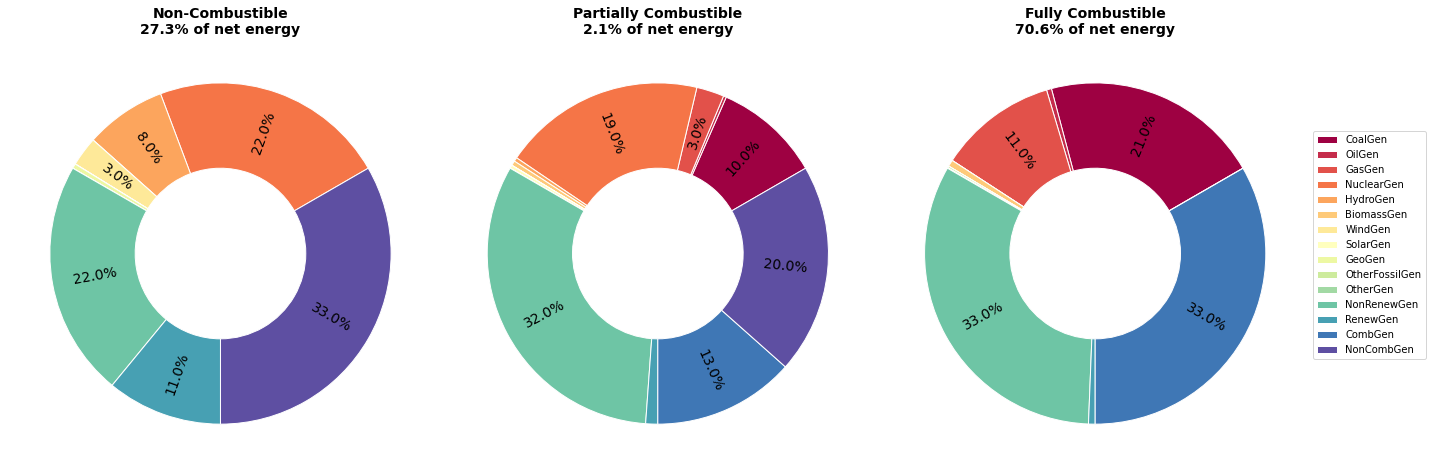

In [342]:
# Combustion plant types
comb_type = {
    1: 'Fully Combustible',
    0.5: 'Partially Combustible',
    0: 'Non-Combustible'
}

# Plotting the pie chart
fig, axs = plt.subplots(1, len(groups), figsize=(20,7))
# fig.patch.set_facecolor('beige')

for n, g in enumerate(groups):
    ax = axs[n]

    patches, labels, pct_texts = ax.pie(
        df_temp.loc[g, gen_types].to_numpy(),
        autopct=lambda p: '{:.1f}%'.format(round(p)) if p >= 2 else '',
        colors=generate_colors('Spectral', len(df_temp.loc[g, gen_types].to_numpy()), 0, 1),
        wedgeprops=dict(width=0.5, edgecolor='w'), radius=1, 
        startangle=30,
        pctdistance=0.75, 
        labeldistance=1.2,
        textprops={'size':14, 'color':'k'},
        rotatelabels=True
    )

    for label, pct_text in zip(labels, pct_texts):
        pct_text.set_rotation(label.get_rotation())

    ax.set_title(comb_type[g] + "\n" + str(round(df_temp.loc[g, 'NetGen'][0]*100,1)) + "% of net energy", fontsize=14, fontweight='bold')

plt.legend(gen_types, bbox_to_anchor=(1,0.8), loc='best')
fig.tight_layout()
plt.show()


In [306]:
df_temp

,NetGen,CoalGen,OilGen,GasGen,NuclearGen,HydroGen,BiomassGen,WindGen,SolarGen,GeoGen,OtherFossilGen,OtherGen,NonRenewGen,RenewGen,CombGen,NonCombGen
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
Combust,,,,,,,,,,,,,,,,
0.0,0.272893,0.000000,0.000000,0.000000,0.183244,0.063054,0.000000,0.022816,0.000097,0.003683,0.000000,0.00000,0.183244,0.089649,0.000000,0.272893
0.5,0.020863,0.006324,0.000171,0.001636,0.012016,0.000233,0.000279,0.000010,0.000192,0.000000,0.000001,0.00000,0.020148,0.000714,0.008411,0.012452
1.0,0.706244,0.440674,0.009994,0.237653,0.000000,0.000000,0.013273,0.000000,0.000000,0.000000,0.003491,0.00116,0.692971,0.013273,0.706244,0.000000


- Combustion plants alone account for 72.7% of the total annual net generation from all plants, meaning that they constitute the primary way that electricity was generated in the US in 2010. 
- Plants with partial combustion represent only 2% of all combustion plants, generating 2.9% of the combustion fueled electricity. 
- It is of prime importance to analyze and understand the emissions associated with the largest source of electricity – fully combustion plants. 
- As a result, for the following exploratory data analysis, plant with partial and no combustion are excluded from the dataset.

In [35]:
# Calculate fraction of energy generated by combustion
comb_gen = sum(df.loc[df['Combust'] != 0, 'NetGen'])/sum(df['NetGen'])

# Calculate fraction of partial cobustion plants and the fraction of combustion fueled energy generated by them
df_temp = df.loc[df['Combust'] != 0]
partial_comb_frac = sum(df_temp['Combust'] == 0.5)/len(df_temp.index)
partial_comb_gen = sum(df_temp.loc[df_temp['Combust'] == 0.5, 'NetGen'])/sum(df_temp['NetGen'])

# Output
print("Full and partial plants generate {comb_gen}% of total energy.".format(comb_gen=round(comb_gen*100,1)))
print("{partial_comb_frac}% of combustion plats are partial combustion. These generate {partial_comb_gen}% of combustion fueled energy.".format(
    partial_comb_frac=round(partial_comb_frac*100,1),
    partial_comb_gen=round(partial_comb_gen*100,1)))

Combustion plants generate 72.7% of total energy.
2.1% of combustion plats are partial combustion. These generate 2.9% of combustion fueled energy.


In [37]:
df_temp = df.loc[df['Combust'] == 1]
primary_fuel_fraction = df_temp.loc[:, 'CoalGen':'OtherGen'].max(axis=1) / df['NetGen']
print(f"Primary fuel accounts for {round(np.mean(primary_fuel_fraction),2)*100}% of total energy generation.")

Primary fuel accounts for 95.0% of total energy generation.


In [17]:
df['FuelCat']

0         OIL
1         GAS
2         OIL
3         OIL
4       HYDRO
        ...  
5388     COAL
5389     COAL
5390     COAL
5391     COAL
5392     WIND
Name: FuelCat, Length: 5393, dtype: object